In [9]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

In [11]:
neighbours = np.load('neighbours.npy')

neighbours

array([[57590,     0, 13595, 26379, 51326],
       [51865,  5915,  3191, 34162, 35134],
       [12248, 18745, 22454, 36018,  8689],
       ...,
       [37770, 30646,  5064, 34563, 32978],
       [44138, 59998, 18127,  8610, 14984],
       [59999, 30453, 43036, 17393, 21735]])

In [5]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

print("x_data shape:", x_data.shape, "- y_data shape:", y_data.shape)

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

x_data shape: (60000, 32, 32, 3) - y_data shape: (60000, 1)


In [7]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

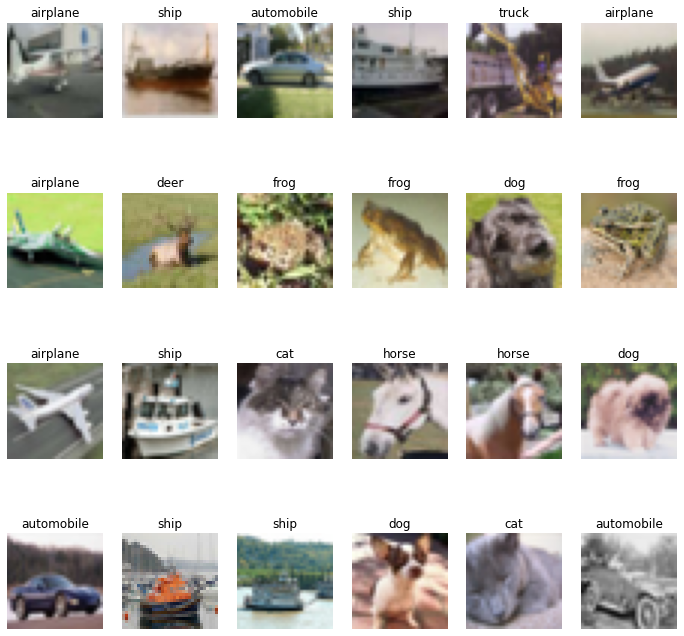

In [14]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        plt.title(classes[y_data[indices[j]][0]])
        plt.axis("off")
        position += 1

In [17]:
anchor_idx = np.random.choice(range(x_data.shape[0]))
neighbour_indicies = neighbours[anchor_idx]
neighbour_indicies

array([ 9540, 27516, 21532, 30078, 19070])

In [ ]:
def cutmix(images, labels):
      imgs = []; labs = []

  for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32) 
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

    w = target_size 
    h = target_size 

    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam) 
    cut_w = tf.cast(w * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(h * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(w/8), int(7/8*w), tf.int32)
    cy = tf.random.uniform((), int(h/8), int(7/8*h), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, w)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, h)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, w)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, h)

    # xmax = tf.clip_by_value(cx + cut_w//2, 0, w)
    # xmax = tf.clip_by_value(cx + cut_h//2, 0, h)
    # ymax = tf.clip_by_value(cy + cut_w//2, 0, w)
    # ymax = tf.clip_by_value(cy + cut_h//2, 0, h)

    mid_left = images[i, ymin:ymax, :xmin, :]
    mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) 
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]

    new_imgs = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_imgs)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin

    alpha = tf.cast((cut_w_mod * cut_h_mod) / (w*h), tf.float32)

    label1 = labels[i] 
    label2 = labels[idx]

    new_label = ((1-alpha) * label1 + alpha * label2) 
    labs.append(new_label)

  new_imgs = tf.reshape(tf.stack(imgs), [-1, target_size, target_size, 3])
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])


  return new_imgs, new_labs